### Importing packages

In [1]:
import pandas as pd
import numpy as np

import spacy
import scipy.sparse as sp
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

tqdm.pandas()

C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_colwidth = 5000

### Reading in dataset

In [3]:
df_ACL_2020 = pd.read_csv("./Data/Pred/BART/ACL_2022_bart_pred_231122.csv")
df_EMNLP_2020 = pd.read_csv("./Data/Pred/BART/EMNLP_2020_bart_pred_231122.csv")

In [4]:
df_ACL_2020 = df_ACL_2020[["Labels", "Paper Name", "abstract"]]
df_EMNLP_2020 = df_EMNLP_2020[["Labels", "Paper Name", "abstract"]]

In [5]:
df_ACL_2020

Labels  \
0    Linguistic Theories, Cognitive Modeling and Psycholinguistics   
1    Linguistic Theories, Cognitive Modeling and Psycholinguistics   
2    Linguistic Theories, Cognitive Modeling and Psycholinguistics   
3    Linguistic Theories, Cognitive Modeling and Psycholinguistics   
4    Linguistic Theories, Cognitive Modeling and Psycholinguistics   
..                                                             ...   
854                                      Student Research Workshop   
855                                      Student Research Workshop   
856                                      Student Research Workshop   
857                                      Student Research Workshop   
858                                      Student Research Workshop   

                                                                                                                     Paper Name  \
0                                                          Overestimation of Syntactic Representation in Neural Language Models   
1    Inflecting When There's No Majority: Limitations of Encoder-Decoder Neural Networks as Cognitive Models for German Plurals   
2                                                 A Systematic Assessment of Syntactic Generalization in Neural Language Models   
3                                 Predicting Depression in Screening Interviews from Latent Categorization of Interview Prompts   
4                                                                                              Probing Linguistic Systematicity   
..                                                                                                                          ...   
854            Media Bias, the Social Sciences, and NLP: Automating Frame Analyses to Identify Bias by Word Choice and Labeling   
855                        Checkpoint Reranking: An Approach to Select Better Hypothesis for Neural Machine Translation Systems   
856                                                          Building a Japanese Typo Dataset from Wikipedia's Revision History   
857                                                                         A Simple and Effective Dependency Parser for Telugu   
858                                              Inducing Grammar from Long Short-Term Memory Networks by Shapley Decomposition   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  abstract  
0                                                                                                                                                                                                                                                                                                

In [6]:
len(df_EMNLP_2020["Labels"].unique())

20

In [7]:
df_ACL_2020['Text'] = df_ACL_2020['Paper Name'] + " " +df_ACL_2020['abstract']
df_EMNLP_2020['Text'] = df_EMNLP_2020['Paper Name'] + " " +df_EMNLP_2020['abstract']

In [8]:
nlp = spacy.load('en_core_web_trf', disable=['parser', 'ner'])
stemmer = SnowballStemmer("english")

In [9]:
def lemmatiser_stemmer_stopword(text, nlp, stemmer):
    
    doc = nlp(text)
    lemmatised_sentence_lst = [token.lemma_ for token in doc if not token.is_stop]
    lemmatised_sentence = " ".join(lemmatised_sentence_lst)
    stemmed_lemmatised_sentence = stemmer.stem(lemmatised_sentence)
    
    return stemmed_lemmatised_sentence.lower()

In [10]:
df_ACL_2020['Lemm Stemmed Text'] = df_ACL_2020['Text'].progress_apply(lemmatiser_stemmer_stopword, args=(nlp, stemmer))

100%|████████████████████████████████████████████████████████████████████████████████| 859/859 [06:10<00:00,  2.32it/s]


In [11]:
df_EMNLP_2020['Lemm Stemmed Text'] = df_EMNLP_2020['Text'].progress_apply(lemmatiser_stemmer_stopword, args=(nlp, stemmer))

100%|████████████████████████████████████████████████████████████████████████████████| 713/713 [05:27<00:00,  2.18it/s]


In [12]:
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

In [13]:
docs_per_class = df_ACL_2020.groupby(['Labels'], as_index=False).agg({'Lemm Stemmed Text': ' '.join})

In [14]:
count = CountVectorizer(ngram_range=(1, 2))
count_trf = count.fit_transform(docs_per_class['Lemm Stemmed Text'])
ctfidf = CTFIDFVectorizer().fit_transform(count_trf, n_samples=len(df_ACL_2020))

In [15]:
# Create bag of words
count_vectorizer = CountVectorizer(ngram_range=(1, 2)).fit(docs_per_class['Lemm Stemmed Text'])
count = count_vectorizer.transform(docs_per_class['Lemm Stemmed Text'])
words = count_vectorizer.get_feature_names()

# Extract top 10 words per class
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(df_ACL_2020)).toarray()
words_per_class = {docs_per_class['Labels'].iloc[label]: [words[index] for index in ctfidf[label].argsort()[-10:]] for label in range(0,len(docs_per_class['Labels']))}

C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
def keyword_count(text): 

    keyword_count_dic = {}

    for label in words_per_class.keys():

        count = 0

        list_of_key_words = words_per_class[label]

        for keyword in list_of_key_words:

            count += text.count(keyword)

        keyword_count_dic[label] = count 
    
    return keyword_count_dic, max(keyword_count_dic, key=keyword_count_dic.get)

### ACL 2020 Predictions

In [17]:
applied_df = df_ACL_2020.apply(lambda row: keyword_count(row['Lemm Stemmed Text']), axis='columns', result_type='expand')
applied_df.columns = ["Dictionary Output", "Predicted Label"]
df_ACL_2020 = pd.concat([df_ACL_2020, applied_df], axis='columns')

In [18]:
df_ACL_2020["Label outcome"] = df_ACL_2020.apply(lambda x: x["Labels"] == x["Predicted Label"], axis = 1)
df_ACL_2020_outcome = df_ACL_2020[['Labels', 'Label outcome']].groupby(['Labels', 'Label outcome']).size().reset_index(name='Counts')
df_ACL_2020_outcome = df_ACL_2020_outcome.sort_values(by = ['Labels','Label outcome'], ascending = [True, False])

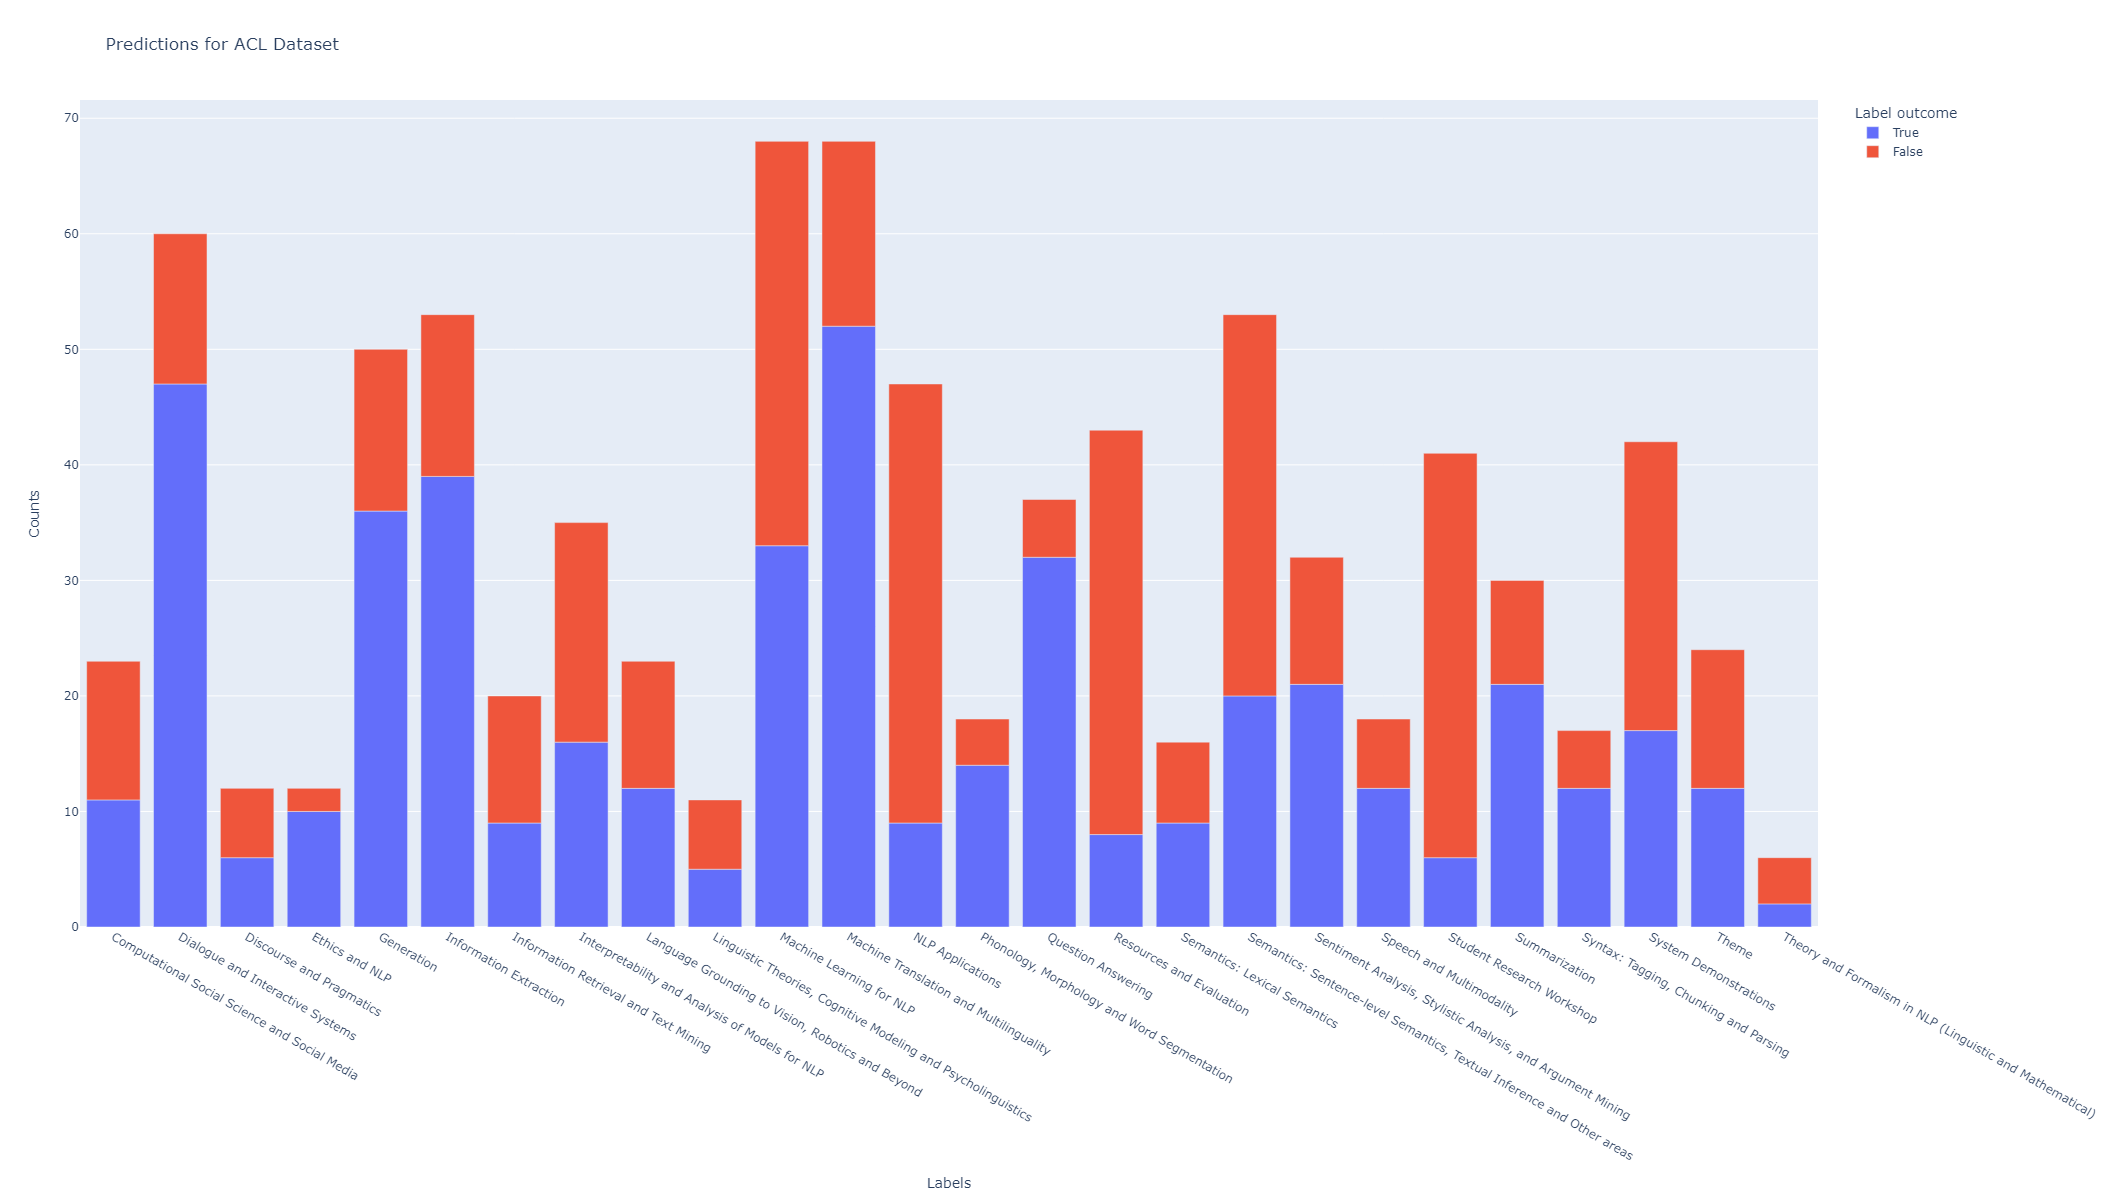

In [19]:
import plotly.express as px

fig = px.bar(df_ACL_2020_outcome, x="Labels", y="Counts", color="Label outcome", title="Predictions for ACL Dataset",
             width=1800, height=1200)
fig.show()

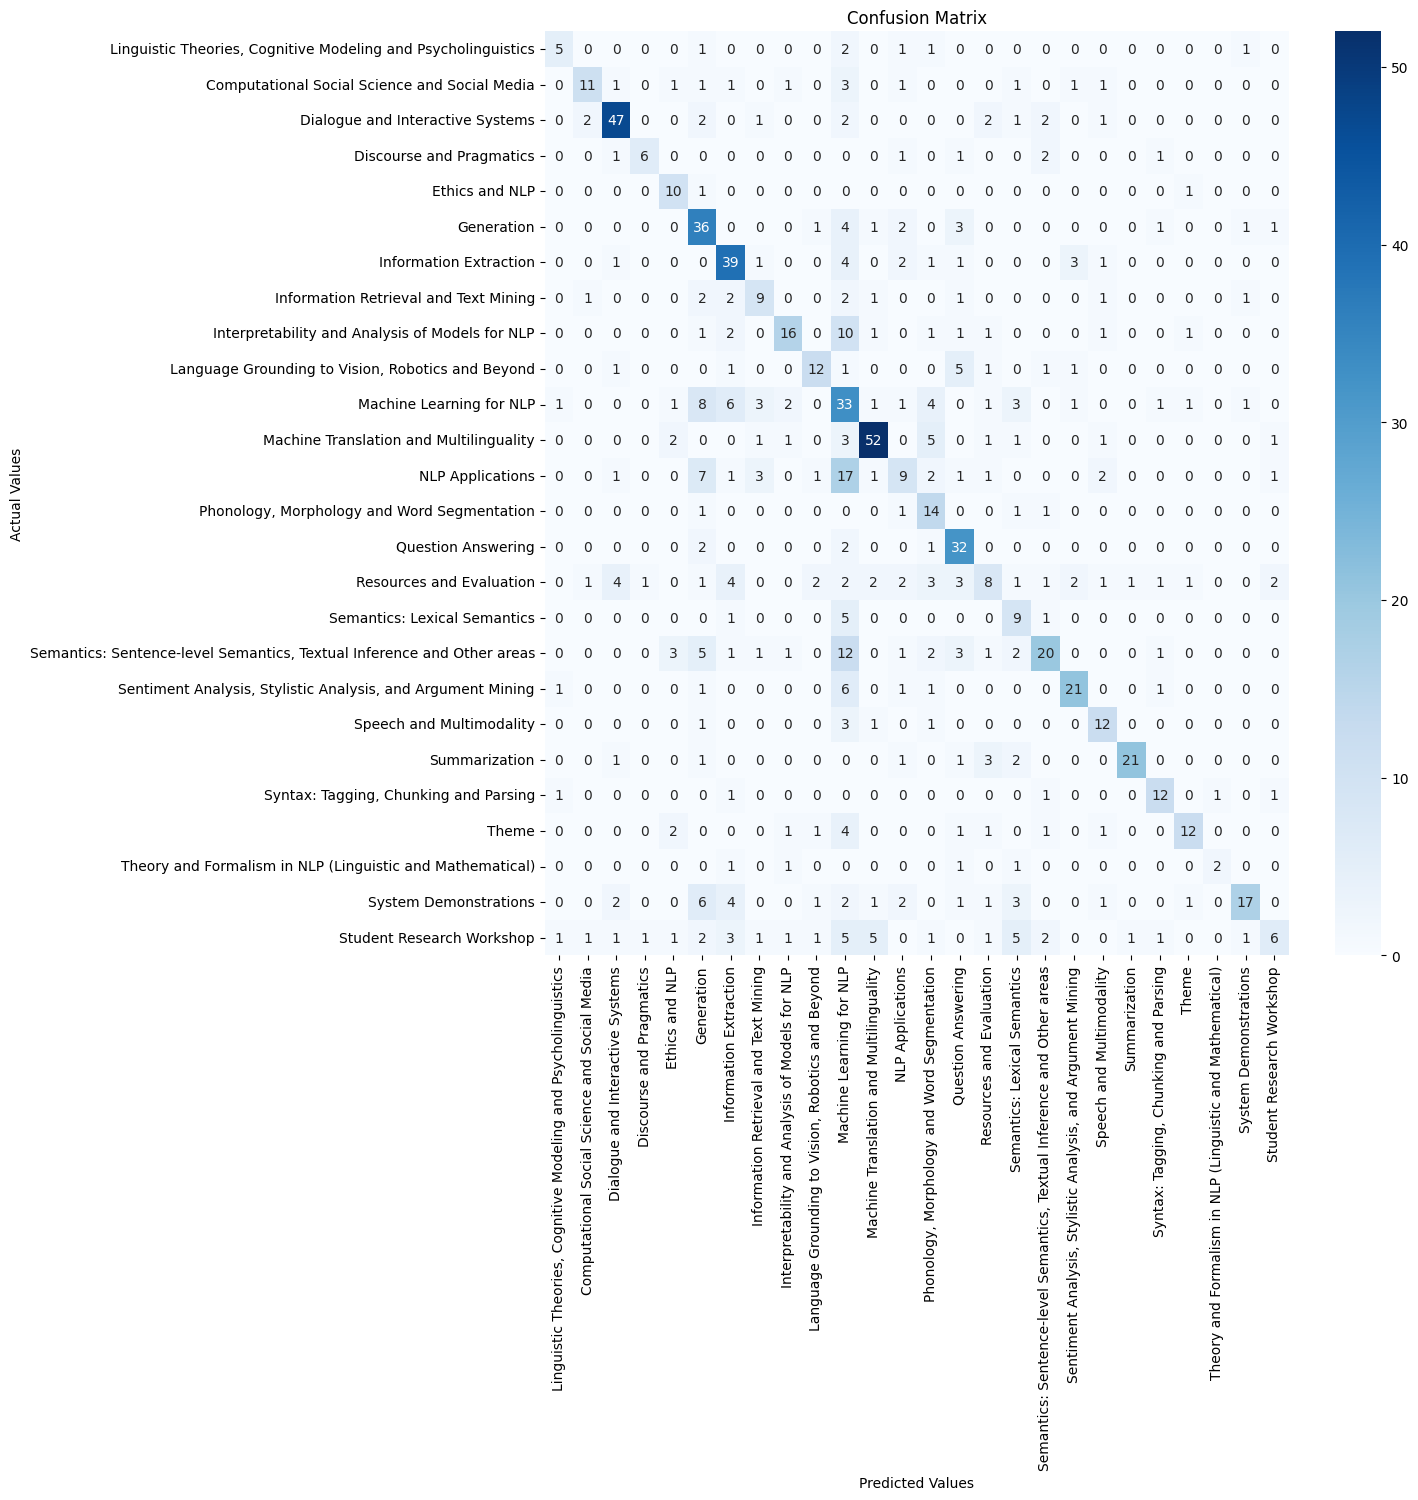

In [20]:
idx_labels = list(df_ACL_2020["Labels"].unique())

cm = confusion_matrix(df_ACL_2020['Labels'], df_ACL_2020['Predicted Label'], labels = idx_labels)
cm_df = pd.DataFrame(cm,
                     index = idx_labels, 
                     columns = idx_labels)

#Plotting the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [21]:
print(classification_report(df_ACL_2020['Labels'], df_ACL_2020['Predicted Label']))

                                                                        precision    recall  f1-score   support

                         Computational Social Science and Social Media       0.69      0.48      0.56        23
                                      Dialogue and Interactive Systems       0.78      0.78      0.78        60
                                              Discourse and Pragmatics       0.75      0.50      0.60        12
                                                        Ethics and NLP       0.50      0.83      0.62        12
                                                            Generation       0.46      0.72      0.56        50
                                                Information Extraction       0.58      0.74      0.65        53
                                 Information Retrieval and Text Mining       0.45      0.45      0.45        20
                       Interpretability and Analysis of Models for NLP       0.67      0.46      0.54  

In [22]:
df_ACL_2020_accuracy = df_ACL_2020_outcome.pivot(index="Labels", columns="Label outcome", values="Counts").reset_index().fillna(0)
df_ACL_2020_accuracy["Accuracy"] = df_ACL_2020_accuracy[True] / (df_ACL_2020_accuracy[False] + df_ACL_2020_accuracy[True]) * 100
df_ACL_2020_accuracy = df_ACL_2020_accuracy.sort_values(by = 'Accuracy', axis=0, ascending=False)
df_ACL_2020_accuracy

Label outcome                                                                  Labels  \
14                                                                 Question Answering   
3                                                                      Ethics and NLP   
1                                                    Dialogue and Interactive Systems   
13                                        Phonology, Morphology and Word Segmentation   
11                                            Machine Translation and Multilinguality   
5                                                              Information Extraction   
4                                                                          Generation   
22                                              Syntax: Tagging, Chunking and Parsing   
21                                                                      Summarization   
19                                                           Speech and Multimodality   
18                        Sentiment Analysis, Stylistic Analysis, and Argument Mining   
16                                                       Semantics: Lexical Semantics   
8                                   Language Grounding to Vision, Robotics and Beyond   
2                                                            Discourse and Pragmatics   
24                                                                              Theme   
10                                                           Machine Learning for NLP   
0                                       Computational Social Science and Social Media   
7                                     Interpretability and Analysis of Models for NLP   
9                       Linguistic Theories, Cognitive Modeling and Psycholinguistics   
6                                               Information Retrieval and Text Mining   
23                                                              System Demonstrations   
17             Semantics: Sentence-level Semantics, Textual Inference and Other areas   
25                          Theory and Formalism in NLP (Linguistic and Mathematical)   
12                                                                   NLP Applications   
15                                                           Resources and Evaluation   
20                                                          Student Research Workshop   

Label outcome  False  True   Accuracy  
14                 5    32  86.486486  
3                  2    10  83.333333  
1                 13    47  78.333333  
13                 4    14  77.777778  
11                16    52  76.470588  
5                 14    39  73.584906  
4                 14    36  72.000000  
22                 5    12  70.588235  
21                 9    21  70.000000  
19                 6    12  66.666667  
18                11    21  65.625000  
16                 7     9  56.250000  
8                 11    12  52.173913  
2                  6     6  50.000000  
24                12    12  50.000000  
10                35    33  48.529412  
0                 12    11  47.826087  
7                 19    16  45.714286  
9                  6     5  45.454545  
6                 11     9  45.000000  
23                25    17  40.476190  
17                33    20  37.735849  
25                 4     2  33.333333  
12                38     9  19.148936  
15                35     8  18.604651  
20                35     6  14.634146

### EMNLP 2020 Predictions

In [23]:
applied_df = df_EMNLP_2020.apply(lambda row: keyword_count(row['Lemm Stemmed Text']), axis='columns', result_type='expand')
applied_df.columns = ["Dictionary Output", "Predicted Label"]
df_EMNLP_2020 = pd.concat([df_EMNLP_2020, applied_df], axis='columns')

In [24]:
df_EMNLP_2020["Label outcome"] = df_EMNLP_2020.apply(lambda x: x["Labels"] == x["Predicted Label"], axis = 1)
df_EMNLP_2020_outcome = df_EMNLP_2020[['Labels', 'Label outcome']].groupby(['Labels', 'Label outcome']).size().reset_index(name='Counts')
df_EMNLP_2020_outcome = df_EMNLP_2020_outcome.sort_values(by = ['Labels','Label outcome'], ascending = [True, False])

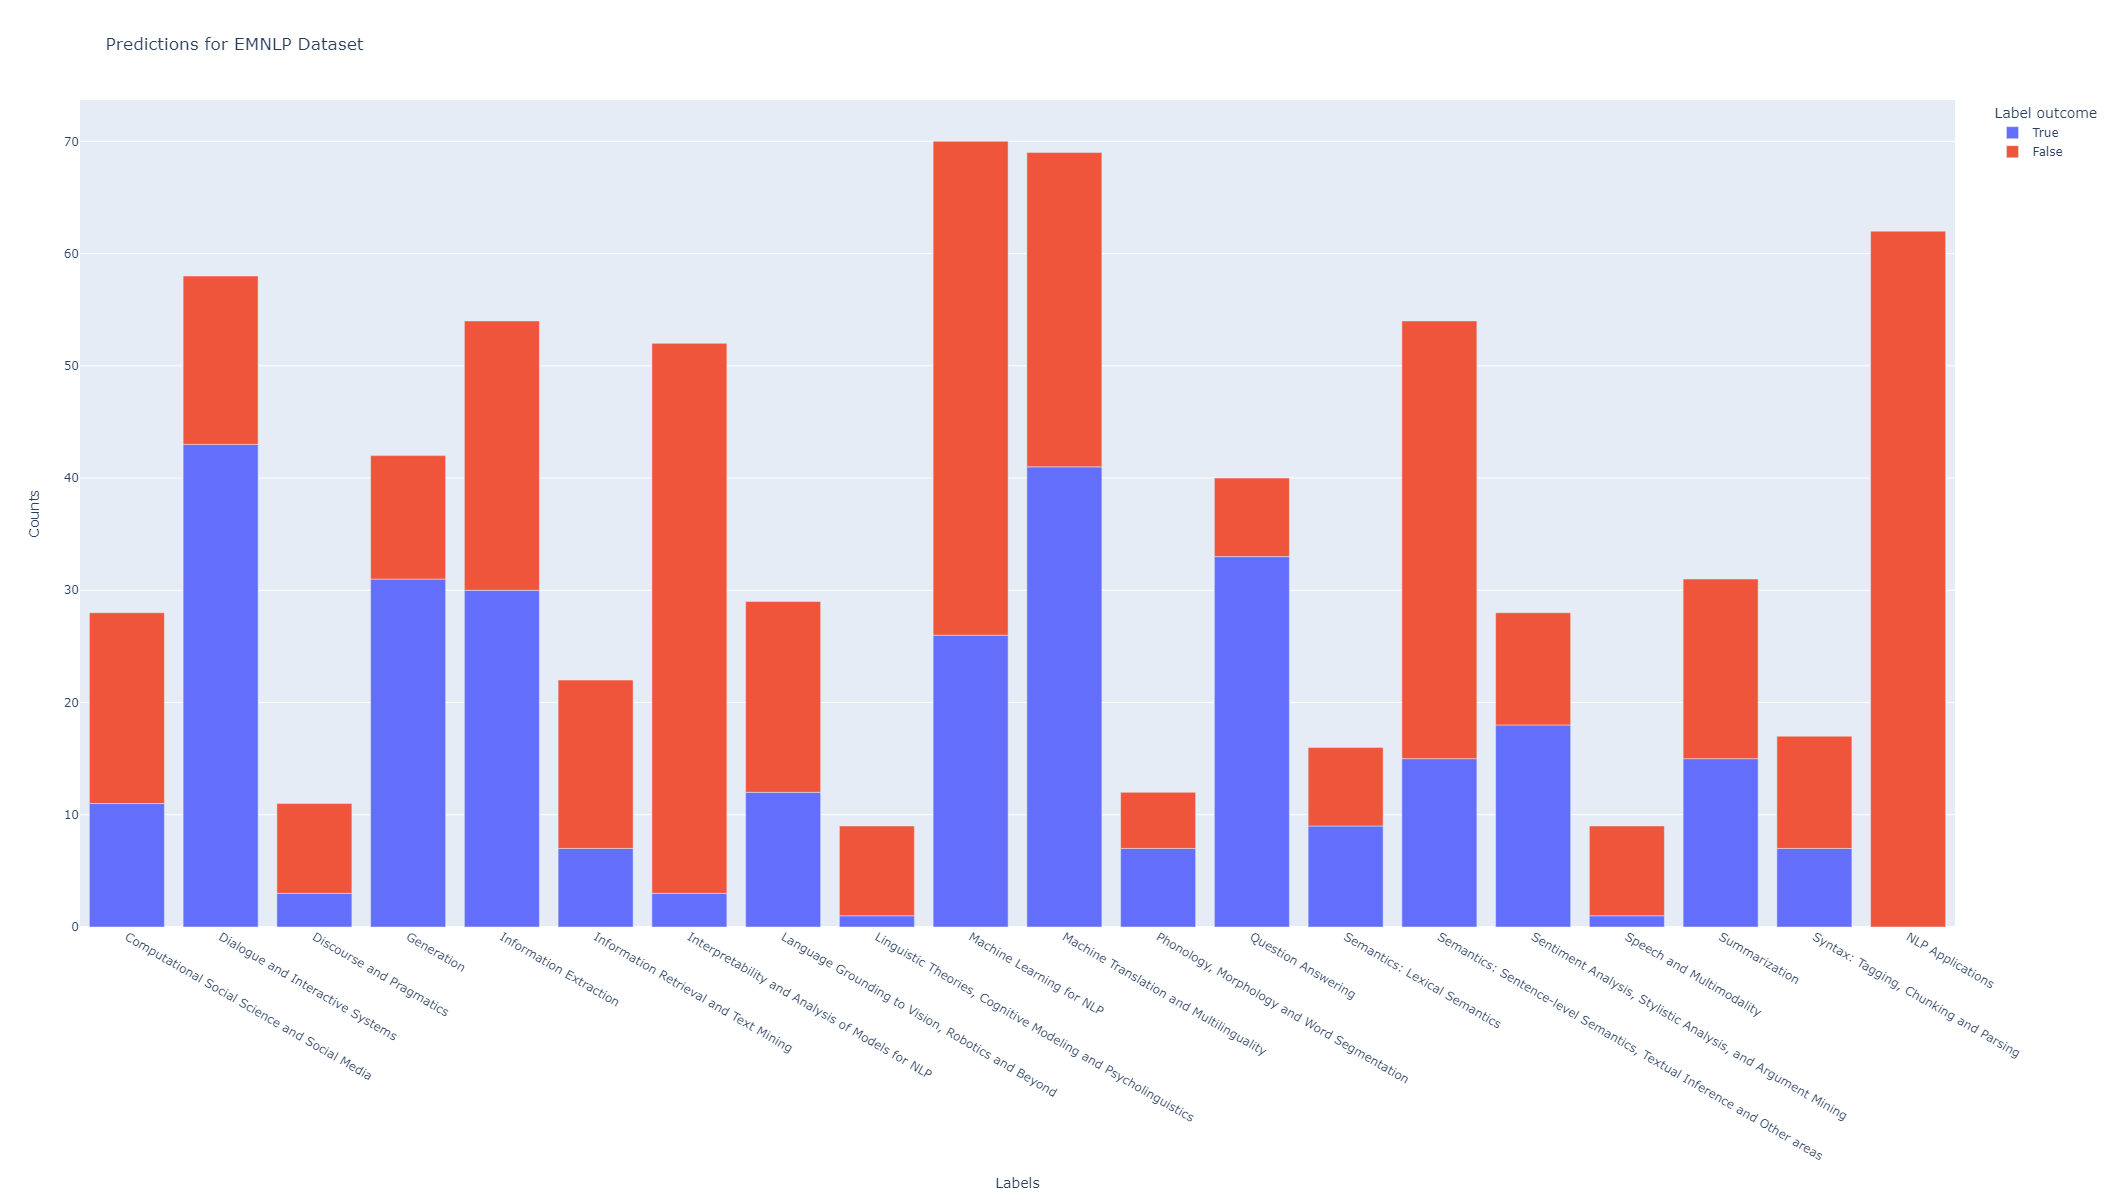

In [25]:
import plotly.express as px

fig = px.bar(df_EMNLP_2020_outcome, x="Labels", y="Counts", color="Label outcome", title="Predictions for EMNLP Dataset",
             width=1800, height=1200)
fig.show()

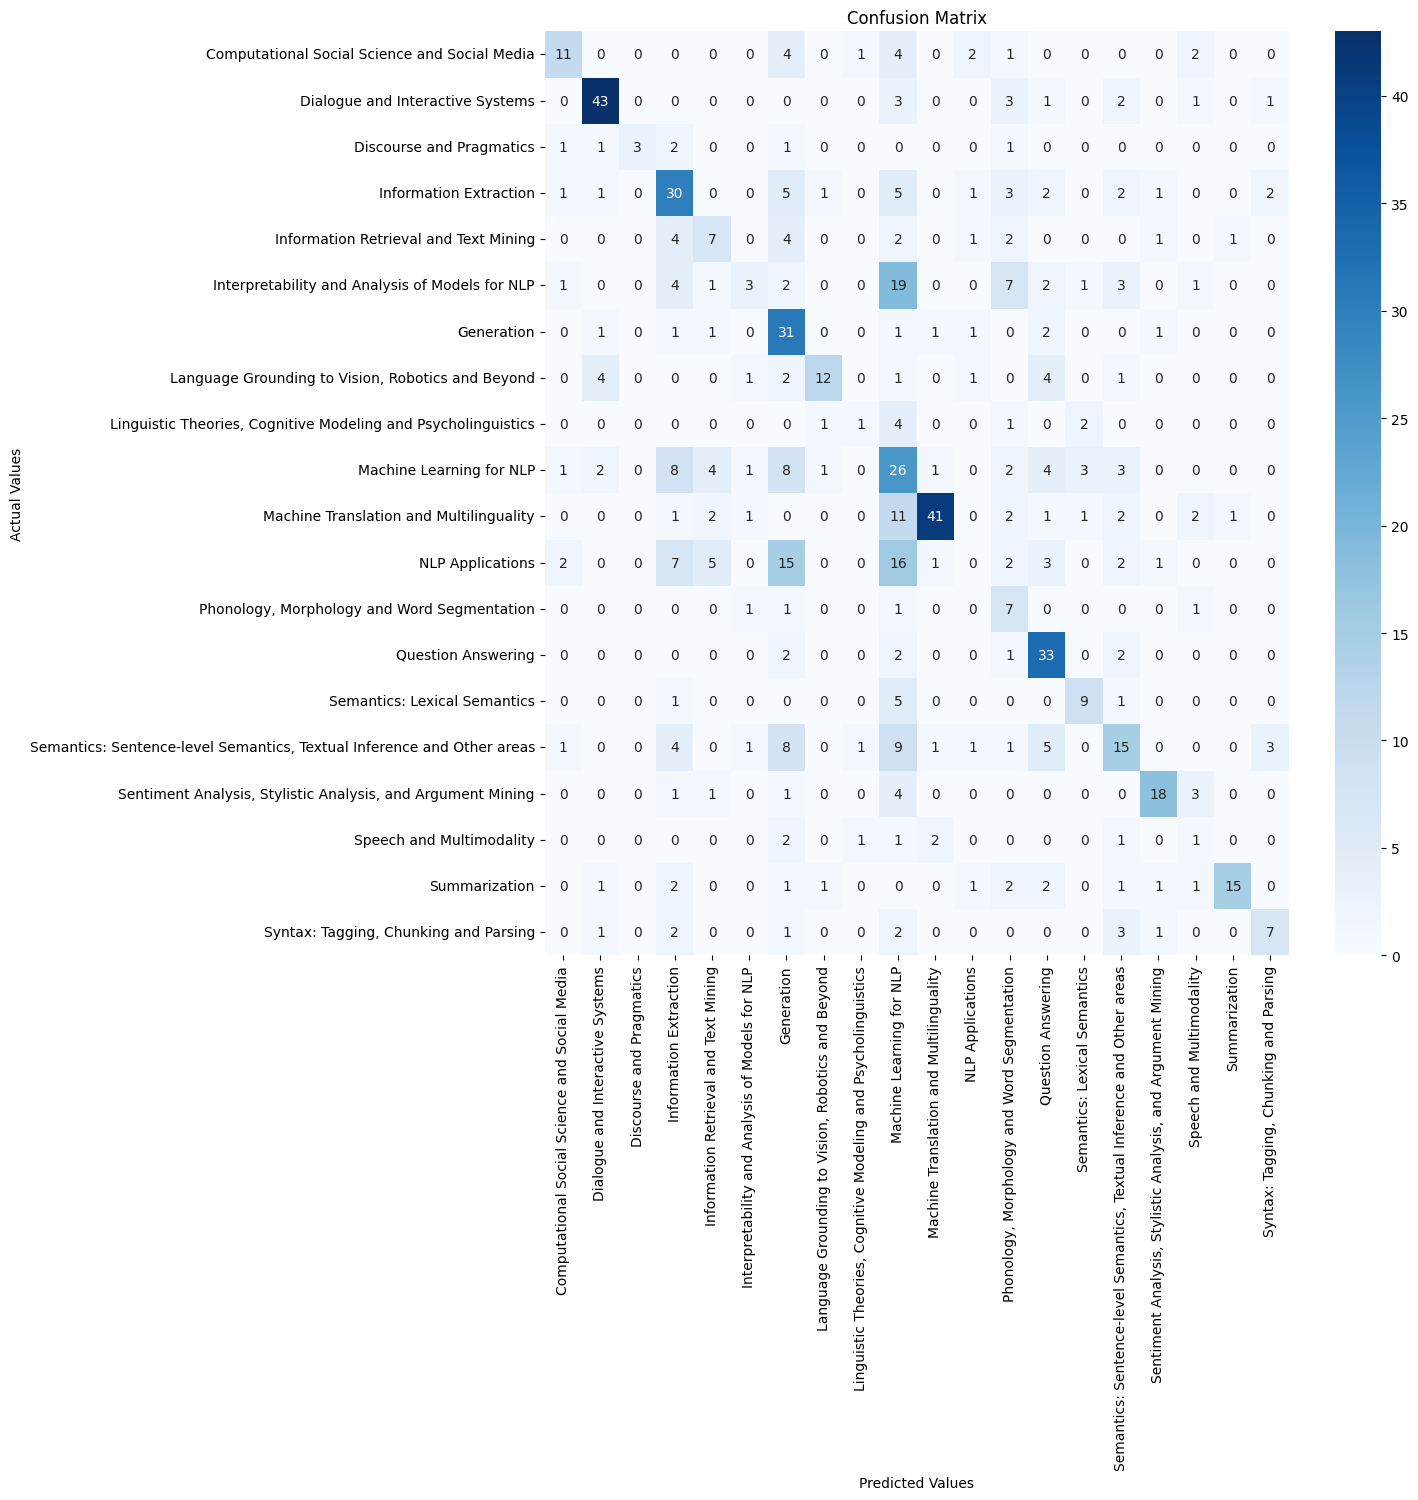

In [26]:
idx_labels = list(df_EMNLP_2020["Labels"].unique())

cm = confusion_matrix(df_EMNLP_2020['Labels'], df_EMNLP_2020['Predicted Label'], labels = idx_labels)
cm_df = pd.DataFrame(cm,
                     index = idx_labels, 
                     columns = idx_labels)

#Plotting the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [29]:
print(classification_report(df_EMNLP_2020['Labels'], df_EMNLP_2020['Predicted Label'], zero_division = 1))

                                                                        precision    recall  f1-score   support

                         Computational Social Science and Social Media       0.61      0.39      0.48        28
                                      Dialogue and Interactive Systems       0.80      0.74      0.77        58
                                              Discourse and Pragmatics       1.00      0.27      0.43        11
                                                        Ethics and NLP       0.00      1.00      0.00         0
                                                            Generation       0.35      0.74      0.48        42
                                                Information Extraction       0.45      0.56      0.50        54
                                 Information Retrieval and Text Mining       0.33      0.32      0.33        22
                       Interpretability and Analysis of Models for NLP       0.38      0.06      0.10  

In [31]:
df_EMNLP_2020_accuracy = df_EMNLP_2020_outcome.pivot(index="Labels", columns="Label outcome", values="Counts").reset_index().fillna(0)
df_EMNLP_2020_accuracy["Accuracy"] = df_EMNLP_2020_accuracy[True] / (df_EMNLP_2020_accuracy[False] + df_EMNLP_2020_accuracy[True]) * 100
df_EMNLP_2020_accuracy = df_EMNLP_2020_accuracy.sort_values(by = 'Accuracy', axis=0, ascending=False)
df_EMNLP_2020_accuracy

Label outcome                                                                  Labels  \
13                                                                 Question Answering   
1                                                    Dialogue and Interactive Systems   
3                                                                          Generation   
16                        Sentiment Analysis, Stylistic Analysis, and Argument Mining   
10                                            Machine Translation and Multilinguality   
12                                        Phonology, Morphology and Word Segmentation   
14                                                       Semantics: Lexical Semantics   
4                                                              Information Extraction   
18                                                                      Summarization   
7                                   Language Grounding to Vision, Robotics and Beyond   
19                                              Syntax: Tagging, Chunking and Parsing   
0                                       Computational Social Science and Social Media   
9                                                            Machine Learning for NLP   
5                                               Information Retrieval and Text Mining   
15             Semantics: Sentence-level Semantics, Textual Inference and Other areas   
2                                                            Discourse and Pragmatics   
8                       Linguistic Theories, Cognitive Modeling and Psycholinguistics   
17                                                           Speech and Multimodality   
6                                     Interpretability and Analysis of Models for NLP   
11                                                                   NLP Applications   

Label outcome  False  True   Accuracy  
13               7.0  33.0  82.500000  
1               15.0  43.0  74.137931  
3               11.0  31.0  73.809524  
16              10.0  18.0  64.285714  
10              28.0  41.0  59.420290  
12               5.0   7.0  58.333333  
14               7.0   9.0  56.250000  
4               24.0  30.0  55.555556  
18              16.0  15.0  48.387097  
7               17.0  12.0  41.379310  
19              10.0   7.0  41.176471  
0               17.0  11.0  39.285714  
9               44.0  26.0  37.142857  
5               15.0   7.0  31.818182  
15              39.0  15.0  27.777778  
2                8.0   3.0  27.272727  
8                8.0   1.0  11.111111  
17               8.0   1.0  11.111111  
6               49.0   3.0   5.769231  
11              62.0   0.0   0.000000

In [33]:
df_ACL_2020.to_csv("./Data/Pred/KeywordMatching/ACL_2020_TFIDF_pred_061222.csv", index = False)
df_EMNLP_2020.to_csv("./Data/Pred/KeywordMatching/EMNLP_2020_TFIDF_pred_061222.csv", index = False)